## A) Introducción:
#### a) Familiarizarse con la clase BCIDataset del notebook asociado al TP. Estudiar el código en detalle. Estudiar los atributos del objeto y su impacto. Estudiar los atributos generados internamente (“resultados”) en la clase en relación a lo charlado en la presentación del TP.
#### b) Estudiar cómo varía el número de ejemplos en el dataset y la dimensión de cada dato según la variación de la ventana de tiempo seleccionada y el criterio de solapamiento.

In [1]:
from pathlib import Path
import pyforest
import utils
from typing import Callable
import scipy
from scipy import signal as sgn
import seaborn

In [2]:
def filtered_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 8
    f_high = 40
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx



def naif_fft_features(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    fft = np.fft.rfft(signal_matrix)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    return Sxx
#devuelve como features las amplitudes del espectro de potencia de cada uno de los ejemplos para cada frecuencia


def generate_df(data,features, chanels): 
    #le paso la data resultante de la extraccion de features, los nombres de los features en una lista y de 
    #los canales
    features_name=[]
    for ch in chanels:
        for feature in features:
            features_name.append(feature + 'ch ' + str (ch))
    return pd.DataFrame(data, columns=features_name)

In [3]:
class BCIDataset():
    def __init__(
        self, 
        csvs_path, 
        subject: str = 'all', 
        session: str = 'all',
        channel: str = 'all', 
        overlapping_fraction: float = 1/3, 
        window_size: int = 900,
        feature_extractor: Callable = naif_fft_features
    ):
        '''
        Object containing all examples from a time series from the dataset.
        Args:
            csvs_path (str): path al directorio donde estan los csv de los datos
            subject (str): sujeto a estudiar.
                Si se indica 'all' el dataset final generado tendrá ejemplos de todos los sujetos
            session (str): sesión a estudiar del sujeto seleccionado.
                si se indica 'all'  el dataset final generado tendrá ejemplos de todas las sesiones
            channel (str): 'ch0', 'ch1', 'ch2', 'ch3'. Si se indica 'all', los ejemplos serán la
                concatenación de los 4 canales.
            overlapping_fraction (float): porcentaje de desplazamiento de la "ventana" que hace el ejemplo
            window_size (int): tamaño de la ventana de tiempo que hace a un ejemplo (en muestras).
            feature_extractor (func): Función de extracción de features, le ingresa un arreglo
                (ejemplos en las filas, muestras en las columnas) y devuelve un arreglo (ejemplos en
                las filas y features en las columnas)
        '''
        self.csvs_path = Path(csvs_path)
        self.channel = channel
        self.parts = int(1 / overlapping_fraction)
        self.fraction = 1 / self.parts
        self.ws = window_size
        self.subject = subject
        self.session = session
        self.channels = ['ch0','ch1','ch2','ch3']
        self.feature_extractor = feature_extractor
        self.complete_dataset = utils.read_all_datasets(self.csvs_path)
        
        self.complete_examples_signal, self.complete_examples_features, \
        self.complete_labels, self.complete_metadata = \
            self.generate_examples()
        
    def generate_examples(self):
        # For each session generate the signal examples,
        # the feature extraction examples and labels arrays
        complete_examples_signal, complete_examples_features = [], []
        complete_labels, complete_metadata = [], []
        
        for subject in self.complete_dataset.subject.unique():
            # Just load the selected subject
            if self.subject != 'all' and subject != self.subject:
                continue
            sessions = \
                self.complete_dataset.loc[self.complete_dataset.subject==subject].session.unique()
            for session in sessions:
                # Just load the selected session
                if self.session != 'all' and session != self.session:
                    continue
                
                print(f'Processing subject: {subject} - session: {session}...')
                
                # Generate a subset of the dataset only with the desired rows
                selection = self.complete_dataset.loc[
                    (self.complete_dataset.subject==subject) &
                    (self.complete_dataset.session==session)
                ]
                
                # Standarize length of the array to a multiple to window size
                labels = selection.label.values
                n_rows = labels.shape[0] // self.ws
                labels = labels[: n_rows * self.ws]

                # Generate examples from the signal
                n_examples = n_rows * self.parts - (self.parts - 1)
                examples = np.empty((n_examples, self.ws))
                most_frec_labels = np.empty((n_examples, self.ws))
                times = np.empty((n_examples, self.ws))
                
                concat_ch_examples_signal, concat_ch_examples_features = [], []

                for k, ch in enumerate(self.channels):
                    # Use the four channels or just one
                    if self.channel != 'all' and self.channel != ch:
                        continue
                    
                    # Standarize length of the signal to a multiple to window size
                    signal = selection[ch].values
                    signal = signal[: n_rows * self.ws]
                    time = selection.time.values
                    time = time[: n_rows * self.ws]

                    # Increase the number of examples by overlapping the windows
                    for part in range(self.parts):
                        
                        # Find the place in the output array for each example
                        position = np.arange(part, n_examples, self.parts)
                        #position = position if part == 0 else position[:-part]

                        # Crop the signal according to the window size and overlap
                        start = int(self.ws / self.parts) * part
                        end = -int(self.ws - (self.ws / self.parts) * part)
                        end = end if part!=0 else signal.shape[0]
                        subset_signal = signal[start:end]
                        subset_labels = labels[start:end]
                        subset_times = time[start:end]

                        # Generate the examples
                        n_rows_ = int(subset_signal.shape[0]/self.ws)
                        examples[position, :] = subset_signal.reshape((n_rows_, self.ws))
                        most_frec_labels[position, :] = subset_labels.reshape((n_rows_, self.ws))
                        times[position, :] = subset_times.reshape((n_rows_, self.ws))
                    
                    # Obtain most frequent label
                    labels_ = scipy.stats.mode(most_frec_labels, axis=1).mode
                    labels_temp = scipy.stats.mode(most_frec_labels, axis=1).count
                    pureness = labels_temp >= self.ws*0.8
                    # Get first and last time of the window
                    times_ = np.asarray([np.min(times, axis=1), np.max(times, axis=1)]).T
                    # Extract features
                    features = self.feature_extractor(examples)

                    concat_ch_examples_signal.append(examples.copy())
                    concat_ch_examples_features.append(features)

                concat_ch_examples_signal = np.concatenate(concat_ch_examples_signal, axis=1)
                concat_ch_examples_features = np.concatenate(concat_ch_examples_features, axis=1)

                complete_examples_signal.append(concat_ch_examples_signal)
                complete_examples_features.append(concat_ch_examples_features)
                complete_labels.append(labels_)
                lt = len(times_)
                metadata_ = np.concatenate(
                    [pureness, times_, np.repeat(subject, lt)[:,None], np.repeat(session, lt)[:,None]],
                    axis=1
                )
                complete_metadata.append(metadata_)

        complete_examples_signal = np.concatenate(complete_examples_signal)
        complete_examples_features = np.concatenate(complete_examples_features)
        complete_labels = np.concatenate(complete_labels)
        complete_metadata = np.concatenate(complete_metadata)
        
        return complete_examples_signal, complete_examples_features, complete_labels, complete_metadata
    
    def __len__(self):
        return self.complete_examples_signal.shape[0]
    
    def __getitem__(self, idx):
        return {
            'signal': self.complete_examples_signal[idx,:],
            'features': self.complete_examples_features[idx,:],
            'label': self.complete_labels[idx,:],
            'metadata': self.complete_metadata[idx,:]
        }

    def get_X_signal(self):
        return self.complete_examples_signal

    def get_X_features(self):
        return self.complete_examples_features

    def get_Y(self):
        return self.complete_labels

    def get_metadata(self):
        return self.complete_metadata


In [4]:
csvs_path = '/home/ariel/gabriel/diplo_de_datos/mentoria_BCI/tp3'
dataset = BCIDataset(csvs_path, subject='AA', session='0')

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
metadata = pd.DataFrame(dataset.complete_metadata, columns = ['purness', 't_start', 't_end', 'subject', 'session'])

<IPython.core.display.Javascript object>

In [6]:
metadata
#me devuelve la matriz de metadata generada por purness (pureza, t_start y t_end son el tiempo de inicio y de fin
#del ejemplo, el subject del cual fue extraido el ejemplo y su sesion)

,purness,t_start,t_end,subject,session
0,True,0.0,4.495,AA,0
1,True,1.5,5.995,AA,0
2,True,3.0,7.495,AA,0
3,True,4.5,8.995,AA,0
4,True,6.0,10.495,AA,0
...,...,...,...,...,...
146,True,219.0,223.495,AA,0
147,True,220.5,224.995,AA,0
148,False,222.0,226.495,AA,0
149,True,223.5,227.995,AA,0


In [7]:
metadata.purness.value_counts()
#son False los valores impuros que contengan mas de una etiqueta 

True     103
False     48
Name: purness, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 6.0)

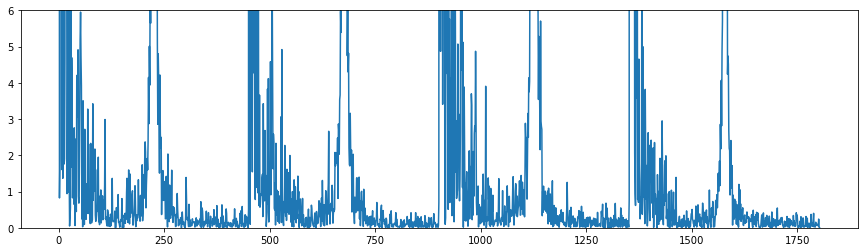

In [8]:
plt.figure(figsize=(15,4))
plt.plot(dataset.complete_examples_features[2,:])
plt.ylim([0,6])
# plt.xlim([8,40])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

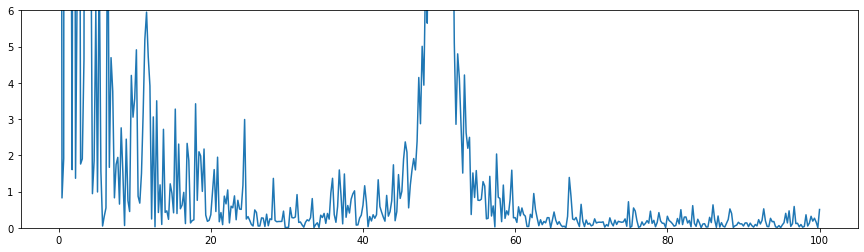

In [9]:
#grafico las frecuencias
N=dataset.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=int(N/4), d=dt)#al usar los cuatro canales hago N/4

plt.figure(figsize=(15,4))
plt.ylim([0,6])
plt.plot(freqs,dataset.complete_examples_features[2,:451])

In [10]:
freqs.shape

(451,)

In [11]:
freqs[1]#esta seria la resolucion de frecuencia?

0.2222222222222222

In [12]:
print('dimension matriz senal ', dataset.get_X_signal().shape)
print('dimension matriz features ', dataset.get_X_features().shape)

#devuelve una matriz donde en cada fila tengo cada ejemplo y en las columnas las features extraidas

dimension matriz senal  (151, 3600)
dimension matriz features  (151, 1804)


In [13]:
dataset.get_Y().shape
#devuelve el vector target

(151, 1)

In [14]:
dataset.__getitem__(0)
#me devuelve el valor de un ejemplo

{'signal': array([ -1.86,  10.77,  87.61, ...,  16.48, -32.06, -62.72]),
 'features': array([2.38843219e+04, 6.95994694e+01, 1.14199542e+01, ...,
        1.18164148e-01, 9.98628650e-02, 4.53153361e-01]),
 'label': array([99.]),
 'metadata': array(['True', '0.0', '4.495', 'AA', '0'], dtype='<U32')}

In [15]:
#pruebo modificando la dimensin del solapamiento
dataset_of1 = BCIDataset(csvs_path, subject='AA', session='0',overlapping_fraction=1/2)
dataset_of1.get_X_features().shape
#disminuye la cantidad de ejemplos al aumentar el solapamiento

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(101, 1804)

In [16]:
#pruebo modificando la dimensin del solapamiento
dataset_of2 = BCIDataset(csvs_path, subject='AA', session='0',overlapping_fraction=1/4)
dataset_of2.get_X_features().shape
#aumenta la cantidad de ejemplos al disminuir el solapamiento

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(201, 1804)

## B) Características Temporales:
#### a) Usando BCIDataset junto con el extractor de features básico de fft (“naif_fft_features”), analice la influencia que tiene el tamaño de la ventana en el dominio de tiempo en la resolución en frecuencia del espectrograma de potencia.

In [17]:
#pruebo modificando la dimensin de la ventana
dataset_ws1 = BCIDataset(csvs_path, subject='AA', session='0',window_size=600)
#el window size tal como esta la clase tiene que ser multiplo de 3 

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
dataset_ws1.get_X_features().shape
#aumenta la cantidad de ejemplos pero disminuye cant de features

(226, 1204)

In [19]:
dataset_ws1.get_X_signal().shape

(226, 2400)

In [20]:
N=dataset_ws1.complete_examples_signal.shape[1]
dt = 1/200
freqs_ws1 = np.fft.rfftfreq(n=int(N/4), d=dt) #al usar los 4 canales hago N/4
print('shape ', freqs_ws1.shape)
print('resolucion ', freqs_ws1[1])

<IPython.core.display.Javascript object>

shape  (301,)
resolucion  0.3333333333333333


In [21]:
#pruebo modificando la dimensin de la ventana
dataset_ws2 = BCIDataset(csvs_path, subject='AA', session='0',window_size=1200)
#el window size tal como esta la clase tiene que ser multiplo de 3 
dataset_ws2.get_X_features().shape
#disminuye la cantidad de ejemplos pero aumentan cant de features

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(112, 2404)

In [22]:
N=dataset_ws2.complete_examples_signal.shape[1]
dt = 1/200
freqs_ws2 = np.fft.rfftfreq(n=int(N/4), d=dt)
print('shape ', freqs_ws2.shape)
print('resolucion ', freqs_ws2[1])

<IPython.core.display.Javascript object>

shape  (601,)
resolucion  0.16666666666666666


al aumentar el tamano de la ventana aumenta la resolucion en frecuencia y si disminuyo el tamano de la ventana disminuye la resolucion en frecuencia. resolucion en frecuencia = f muestreo/tamano de la ventana.
resolucion en frecuencia = 200/(tamano de la ventana)
Esta resolucion es inversa a la resolucion en el tiempo ya que al aumentar la ventana se generan menos cantidad de ejemplos temporales.

In [23]:
200/0.25#tamano de la ventana que se va a utilizar adelante

800.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

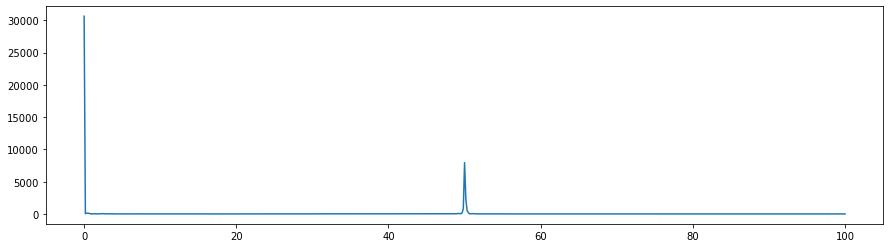

In [24]:
N=dataset_ws2.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=int(N/4), d=dt)

plt.figure(figsize=(15,4))
#plt.ylim([0,6])
plt.plot(freqs,dataset_ws2.complete_examples_features[2,:601])

#### b) Teniendo en cuenta el inciso anterior, las frecuencias de estimulación y la frecuencia de muestreo pertinentes, ¿cuál considera que es el número adecuado de muestras temporales que puede recortar conservando la mayor cantidad de información útil en el dominio de la frecuencia? (t).

creo que la resolucion en frecuencia pertinente podria ser 0,5/2 ya que 0,5 Hz es el minimo paso que nuestra senal va a expresar debido a que la frecuencia de estimulacion esta en 12,5 y 16,5 Hz. Usaria 0,25 Hz o menor como un factor de seguridad que voy a tomar la variacion de senal correspondiente. A uno le gustaria tomar la resolucion mas pequena posible pero eso conlleva a una mala resolucion en el tiempo y por ende a muy poca cantidad de muestras disponibles para realizar el analisis.

In [25]:
#pruebo modificando la dimensi0n de la ventana tal que su resolucion en frec sea menor a 0,25Hz
dataset_ws3 = BCIDataset(csvs_path, subject='AA', session='0',window_size=750)
#el window size tal como esta la clase tiene que ser multiplo de 3 
dataset_ws3.get_X_features().shape

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(181, 1504)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 6.0)

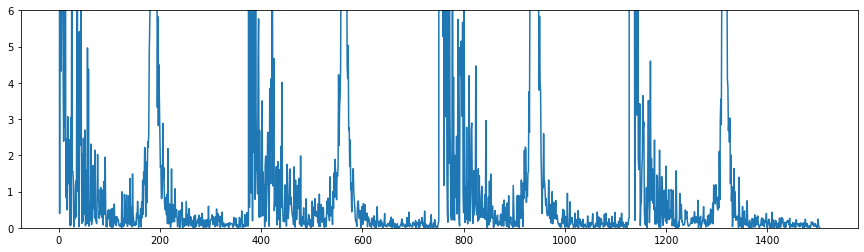

In [26]:
plt.figure(figsize=(15,4))
plt.plot(dataset_ws3.complete_examples_features[2,:])
plt.ylim([0,6])
# plt.xlim([8,40])

In [27]:
N=dataset_ws3.complete_examples_signal.shape[1]
dt = 1/200
freqs_ws3 = np.fft.rfftfreq(n=int(N/4), d=dt)
print('shape ', freqs_ws3.shape)
print('resolucion ', freqs_ws3[1])
#vemos una resolucion menor a 0,25 Hz
N

<IPython.core.display.Javascript object>

shape  (376,)
resolucion  0.26666666666666666


3000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

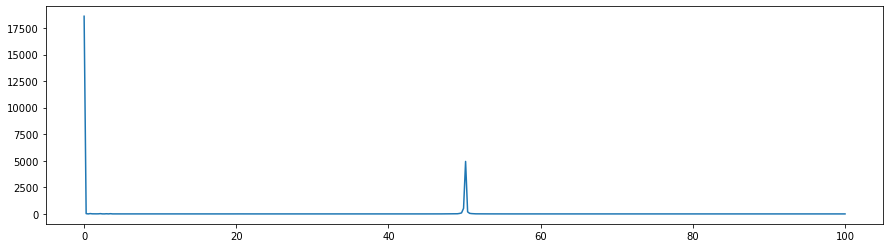

In [28]:
plt.figure(figsize=(15,4))
#plt.ylim([0,6])
plt.plot(freqs_ws3,dataset_ws3.complete_examples_features[2,:376])

#### c) En adición a la serie temporal cruda -”complete_examples_signal”- (concatenada o no a lo largo de los canales, según su elección), defina una estrategia de extracción de atributos en el dominio de tiempo que opere sobre la serie cruda, ejemplo: algún criterio como la media en cada canal para el ejemplo. Sean creativos pero no dediquen mucho tiempo a este inciso, es más bien para tener un punto de comparación.

In [212]:
def filtered_time_features_max(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    #fft = np.fft.rfft(sig_filt)
    #Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    
    #filt_sgn_time=np.fft.irfft(Sxx)
    #obtengo la senal en tiempo ya filtrada
    
    maximum=sig_filt.max(axis=1)
    #minimum=filt_sgn_time.min(axis=1)
    #mean=filt_sgn_time.mean(axis=1)
    #median=filt_sgn_time.median(axis=1)
    #std=filt_sgn_time.std(axis=1)
    #calculo sus estadisticos
    
    return np.array([maximum]).reshape((signal_matrix.shape[0], 1))#,minimum+ 10,mean+100,  std
    
    

In [213]:
dataset_time_features_max = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_time_features_max)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [214]:
df_time_features_max=generate_df(dataset_time_features_max.complete_examples_features.round(2),['maximum '], [0,1,2,3])

<IPython.core.display.Javascript object>

In [215]:
df_time_features_max

,maximum ch 0,maximum ch 1,maximum ch 2,maximum ch 3
0,16.41,13.79,12.00,12.68
1,87.09,95.14,88.83,84.57
2,89.23,97.29,90.52,86.28
3,89.23,97.29,90.52,86.28
4,16.87,13.56,17.68,13.91
...,...,...,...,...
2609,22.58,17.82,21.92,24.04
2610,17.34,15.74,16.80,18.86
2611,22.35,17.14,17.29,26.27
2612,18.51,15.02,18.79,19.97


In [216]:
def filtered_time_features_min(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    #fft = np.fft.rfft(sig_filt)
    #Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    
    #filt_sgn_time=np.fft.irfft(Sxx)
    #obtengo la senal en tiempo ya filtrada
    
    #maximum=filt_sgn_time.max(axis=1)
    minimum=sig_filt.min(axis=1)
    #mean=filt_sgn_time.mean(axis=1)
    #median=filt_sgn_time.median(axis=1)
    #std=filt_sgn_time.std(axis=1)
    #calculo sus estadisticos
    
    return np.array([minimum]).reshape((signal_matrix.shape[0], 1))#,minimum+ 10,mean+100,  std

In [217]:
dataset_time_features_min = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_time_features_min)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [219]:
df_time_features_min=generate_df(dataset_time_features_min.complete_examples_features.round(2),['minimum '], [0,1,2,3])
df_time_features_min

<IPython.core.display.Javascript object>

,minimum ch 0,minimum ch 1,minimum ch 2,minimum ch 3
0,-15.24,-12.06,-13.25,-12.35
1,-78.71,-89.40,-83.87,-76.78
2,-76.70,-86.99,-81.68,-74.58
3,-76.70,-86.99,-81.68,-74.58
4,-12.39,-12.67,-15.47,-12.70
...,...,...,...,...
2609,-18.02,-14.88,-16.50,-16.97
2610,-18.03,-14.88,-16.50,-16.97
2611,-12.96,-11.27,-11.27,-12.36
2612,-12.78,-11.45,-13.60,-14.13


In [223]:
def filtered_time_features_mean(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    #fft = np.fft.rfft(sig_filt)
    #Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    
    #filt_sgn_time=np.fft.irfft(Sxx)
    #obtengo la senal en tiempo ya filtrada
    
    #maximum=filt_sgn_time.max(axis=1)
    #minimum=sig_filt.min(axis=1)
    mean=sig_filt.mean(axis=1)
    #median=filt_sgn_time.median(axis=1)
    #std=filt_sgn_time.std(axis=1)
    #calculo sus estadisticos
    
    return np.array([mean]).reshape((signal_matrix.shape[0], 1))#,minimum+ 10,mean+100,  std

def filtered_time_features_median(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    #fft = np.fft.rfft(sig_filt)
    #Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    
    #filt_sgn_time=np.fft.irfft(Sxx)
    #obtengo la senal en tiempo ya filtrada
    
    #maximum=filt_sgn_time.max(axis=1)
    #minimum=sig_filt.min(axis=1)
    #mean=sig_filt.mean(axis=1)
    median=np.median(sig_filt,axis=1)
    #std=filt_sgn_time.std(axis=1)
    #calculo sus estadisticos
    
    return np.array([median]).reshape((signal_matrix.shape[0], 1))#,minimum+ 10,mean+100,  std

In [221]:
dataset_time_features_mean = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_time_features_mean)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [222]:
df_time_features_mean=generate_df(dataset_time_features_mean.complete_examples_features.round(2),['mean '],
                                  [0,1,2,3])
df_time_features_mean

<IPython.core.display.Javascript object>

,mean ch 0,mean ch 1,mean ch 2,mean ch 3
0,0.03,0.07,0.03,0.03
1,0.01,0.01,0.02,0.01
2,0.01,0.00,0.02,0.01
3,0.01,-0.03,0.01,0.01
4,-0.01,0.00,0.00,0.01
...,...,...,...,...
2609,-0.01,-0.01,0.00,-0.02
2610,0.01,0.02,0.03,0.01
2611,0.05,0.06,0.05,0.07
2612,0.02,0.02,-0.01,0.01


In [224]:
dataset_time_features_median = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_time_features_median)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [225]:
df_time_features_median=generate_df(dataset_time_features_median.complete_examples_features.round(2),['median '],
                                  [0,1,2,3])
df_time_features_median

<IPython.core.display.Javascript object>

,median ch 0,median ch 1,median ch 2,median ch 3
0,-0.01,-0.01,0.21,0.07
1,-0.02,-0.06,-0.06,0.01
2,-0.02,-0.08,-0.11,-0.02
3,0.06,-0.04,-0.11,-0.01
4,0.09,-0.01,0.08,0.07
...,...,...,...,...
2609,-0.13,0.00,-0.05,-0.06
2610,0.02,-0.04,0.01,-0.02
2611,0.04,0.01,0.11,-0.06
2612,-0.02,-0.13,0.08,-0.14


#### d) Guarde los datasets generados de la forma que considere conveniente.

In [226]:
time_features = df_time_features_max.merge(df_time_features_min,left_index=True,right_index=True)
time_features= time_features.merge(df_time_features_mean,left_index=True,right_index=True)
time_features= time_features.merge(df_time_features_median,left_index=True,right_index=True)
time_features
#realizo el merge de los df

,maximum ch 0,maximum ch 1,maximum ch 2,maximum ch 3,minimum ch 0,minimum ch 1,minimum ch 2,minimum ch 3,mean ch 0,mean ch 1,mean ch 2,mean ch 3,median ch 0,median ch 1,median ch 2,median ch 3
0,16.41,13.79,12.00,12.68,-15.24,-12.06,-13.25,-12.35,0.03,0.07,0.03,0.03,-0.01,-0.01,0.21,0.07
1,87.09,95.14,88.83,84.57,-78.71,-89.40,-83.87,-76.78,0.01,0.01,0.02,0.01,-0.02,-0.06,-0.06,0.01
2,89.23,97.29,90.52,86.28,-76.70,-86.99,-81.68,-74.58,0.01,0.00,0.02,0.01,-0.02,-0.08,-0.11,-0.02
3,89.23,97.29,90.52,86.28,-76.70,-86.99,-81.68,-74.58,0.01,-0.03,0.01,0.01,0.06,-0.04,-0.11,-0.01
4,16.87,13.56,17.68,13.91,-12.39,-12.67,-15.47,-12.70,-0.01,0.00,0.00,0.01,0.09,-0.01,0.08,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,22.58,17.82,21.92,24.04,-18.02,-14.88,-16.50,-16.97,-0.01,-0.01,0.00,-0.02,-0.13,0.00,-0.05,-0.06
2610,17.34,15.74,16.80,18.86,-18.03,-14.88,-16.50,-16.97,0.01,0.02,0.03,0.01,0.02,-0.04,0.01,-0.02
2611,22.35,17.14,17.29,26.27,-12.96,-11.27,-11.27,-12.36,0.05,0.06,0.05,0.07,0.04,0.01,0.11,-0.06
2612,18.51,15.02,18.79,19.97,-12.78,-11.45,-13.60,-14.13,0.02,0.02,-0.01,0.01,-0.02,-0.13,0.08,-0.14


#### e) Para cada dataset, analice la contribución de información de cada feature estudiado al propósito de clasificación. Estudie la correlación entre features. Estudie la correlación entre features y etiquetas. En conjunto con la exploración de los TP anteriores, ¿considera útil estos atributos?

In [227]:
labels = pd.DataFrame(dataset_time_features_max.complete_labels,columns=['labels'])

<IPython.core.display.Javascript object>

In [228]:
time_features_labels = time_features.merge(labels,left_index=True,right_index=True)
time_features_labels

,maximum ch 0,maximum ch 1,maximum ch 2,maximum ch 3,minimum ch 0,minimum ch 1,minimum ch 2,minimum ch 3,mean ch 0,mean ch 1,mean ch 2,mean ch 3,median ch 0,median ch 1,median ch 2,median ch 3,labels
0,16.41,13.79,12.00,12.68,-15.24,-12.06,-13.25,-12.35,0.03,0.07,0.03,0.03,-0.01,-0.01,0.21,0.07,99.0
1,87.09,95.14,88.83,84.57,-78.71,-89.40,-83.87,-76.78,0.01,0.01,0.02,0.01,-0.02,-0.06,-0.06,0.01,99.0
2,89.23,97.29,90.52,86.28,-76.70,-86.99,-81.68,-74.58,0.01,0.00,0.02,0.01,-0.02,-0.08,-0.11,-0.02,99.0
3,89.23,97.29,90.52,86.28,-76.70,-86.99,-81.68,-74.58,0.01,-0.03,0.01,0.01,0.06,-0.04,-0.11,-0.01,99.0
4,16.87,13.56,17.68,13.91,-12.39,-12.67,-15.47,-12.70,-0.01,0.00,0.00,0.01,0.09,-0.01,0.08,0.07,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,22.58,17.82,21.92,24.04,-18.02,-14.88,-16.50,-16.97,-0.01,-0.01,0.00,-0.02,-0.13,0.00,-0.05,-0.06,1.0
2610,17.34,15.74,16.80,18.86,-18.03,-14.88,-16.50,-16.97,0.01,0.02,0.03,0.01,0.02,-0.04,0.01,-0.02,1.0
2611,22.35,17.14,17.29,26.27,-12.96,-11.27,-11.27,-12.36,0.05,0.06,0.05,0.07,0.04,0.01,0.11,-0.06,1.0
2612,18.51,15.02,18.79,19.97,-12.78,-11.45,-13.60,-14.13,0.02,0.02,-0.01,0.01,-0.02,-0.13,0.08,-0.14,1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,maximum ch 0,maximum ch 1,maximum ch 2,maximum ch 3,minimum ch 0,minimum ch 1,minimum ch 2,minimum ch 3,mean ch 0,mean ch 1,mean ch 2,mean ch 3,median ch 0,median ch 1,median ch 2,median ch 3,labels
maximum ch 0,1.000000,0.857222,0.923085,0.886146,-0.999684,-0.855663,-0.925216,-0.885140,-0.173457,-0.013377,-0.007817,-0.157128,-0.223237,0.002925,-0.064586,-0.467647,0.080942
maximum ch 1,0.857222,1.000000,0.855344,0.828272,-0.856004,-0.998864,-0.856523,-0.827443,-0.255539,0.023518,-0.049419,-0.212434,-0.131235,-0.168659,-0.167555,-0.475550,0.078858
maximum ch 2,0.923085,0.855344,1.000000,0.930579,-0.920447,-0.854880,-0.999572,-0.931604,-0.217548,-0.040643,-0.012888,-0.282386,-0.187698,-0.048854,-0.080508,-0.413604,0.077042
maximum ch 3,0.886146,0.828272,0.930579,1.000000,-0.882855,-0.826488,-0.932619,-0.999718,-0.289108,-0.099141,-0.060866,-0.316316,-0.192962,0.047852,0.049196,-0.406757,0.076414
minimum ch 0,-0.999684,-0.856004,-0.920447,-0.882855,1.000000,0.854518,0.922895,0.881971,0.161968,0.000988,-0.002327,0.151279,0.223083,-0.002659,0.063604,0.470153,-0.081281
minimum ch 1,-0.855663,-0.998864,-0.854880,-0.826488,0.854518,1.000000,0.856479,0.825733,0.257333,0.004296,0.068853,0.195572,0.130999,0.153415,0.154189,0.464776,-0.078861
minimum ch 2,-0.925216,-0.856523,-0.999572,-0.932619,0.922895,0.856479,1.000000,0.933699,0.223105,0.045324,0.020543,0.283519,0.190977,0.045307,0.074980,0.414718,-0.077372
minimum ch 3,-0.885140,-0.827443,-0.931604,-0.999718,0.881971,0.825733,0.933699,1.000000,0.292129,0.100973,0.062824,0.324949,0.192232,-0.046089,-0.044727,0.406246,-0.076349
mean ch 0,-0.173457,-0.255539,-0.217548,-0.289108,0.161968,0.257333,0.223105,0.292129,1.000000,0.698187,0.742915,0.536427,0.022081,-0.031648,0.077510,0.028995,-0.007920
mean ch 1,-0.013377,0.023518,-0.040643,-0.099141,0.000988,0.004296,0.045324,0.100973,0.698187,1.000000,0.861339,0.132089,-0.012447,-0.319996,-0.241421,-0.270827,0.006161


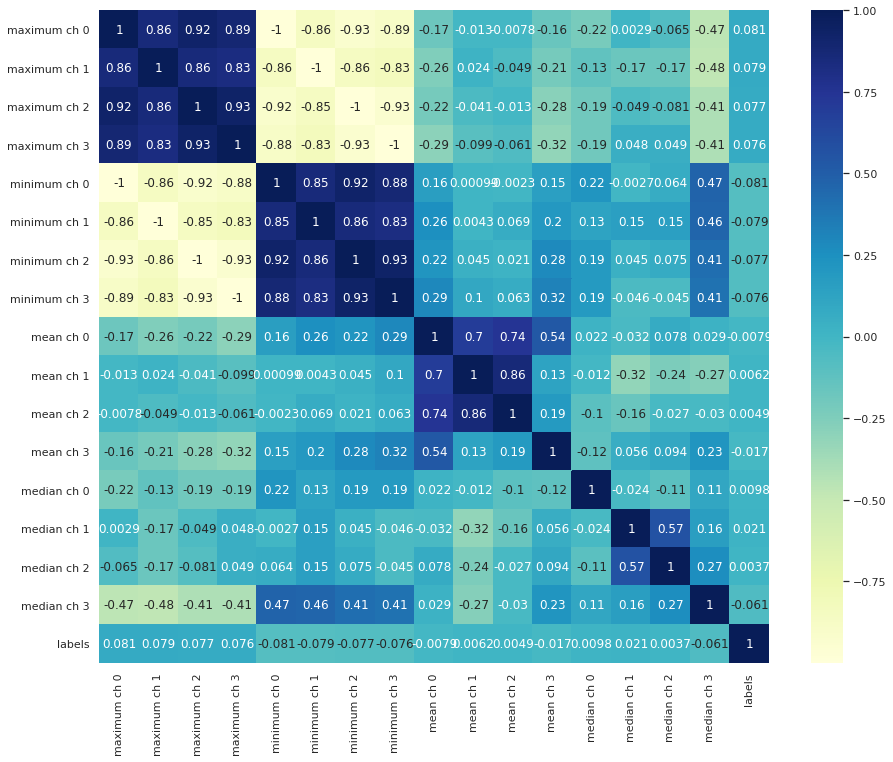

In [229]:
#usando labels 99
time_features_labels=time_features_labels[time_features_labels['labels'].isin([1, 2,99])]
#veo correlacion entre los features
corr_col=time_features_labels.corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(15,12)})
corr_col
#se ve correlacion entre features pero no entre los features y los labels


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,maximum ch 0,maximum ch 1,maximum ch 2,maximum ch 3,minimum ch 0,minimum ch 1,minimum ch 2,minimum ch 3,mean ch 0,mean ch 1,mean ch 2,mean ch 3,median ch 0,median ch 1,median ch 2,median ch 3,labels
maximum ch 0,1.000000,0.886663,0.888709,0.529164,-0.530046,-0.476539,-0.484022,-0.355109,0.386558,0.385608,0.410287,0.063163,0.004678,-0.005281,-0.002771,0.019910,0.001274
maximum ch 1,0.886663,1.000000,0.918410,0.544234,-0.471138,-0.532907,-0.494723,-0.373778,0.391488,0.414493,0.432782,0.070244,0.045457,0.009891,0.044813,0.021313,0.038609
maximum ch 2,0.888709,0.918410,1.000000,0.400587,-0.488185,-0.504900,-0.546422,-0.339900,0.362319,0.383019,0.436624,-0.027416,0.021107,0.004198,0.023669,0.018316,-0.015433
maximum ch 3,0.529164,0.544234,0.400587,1.000000,-0.327537,-0.340871,-0.296504,-0.495015,0.244086,0.228468,0.156294,0.370535,0.075723,0.045427,0.088433,0.056757,0.016620
minimum ch 0,-0.530046,-0.471138,-0.488185,-0.327537,1.000000,0.905838,0.888205,0.582771,0.376203,0.360373,0.347024,0.221167,-0.031992,-0.034539,-0.038588,-0.016513,-0.022882
minimum ch 1,-0.476539,-0.532907,-0.504900,-0.340871,0.905838,1.000000,0.921266,0.605787,0.368588,0.392183,0.360949,0.219015,-0.058235,-0.049603,-0.071973,-0.033990,-0.033852
minimum ch 2,-0.484022,-0.494723,-0.546422,-0.296504,0.888205,0.921266,1.000000,0.450738,0.324194,0.330317,0.348921,0.089188,-0.026502,-0.032333,-0.042854,-0.026424,0.004061
minimum ch 3,-0.355109,-0.373778,-0.339900,-0.495015,0.582771,0.605787,0.450738,1.000000,0.228397,0.244032,0.145013,0.479005,-0.084994,-0.044599,-0.114160,-0.057918,-0.021679
mean ch 0,0.386558,0.391488,0.362319,0.244086,0.376203,0.368588,0.324194,0.228397,1.000000,0.922219,0.903467,0.490300,0.037158,-0.014620,0.012127,0.033628,-0.008568
mean ch 1,0.385608,0.414493,0.383019,0.228468,0.360373,0.392183,0.330317,0.244032,0.922219,1.000000,0.938462,0.459570,-0.000421,-0.014990,0.010247,0.010273,-0.000572


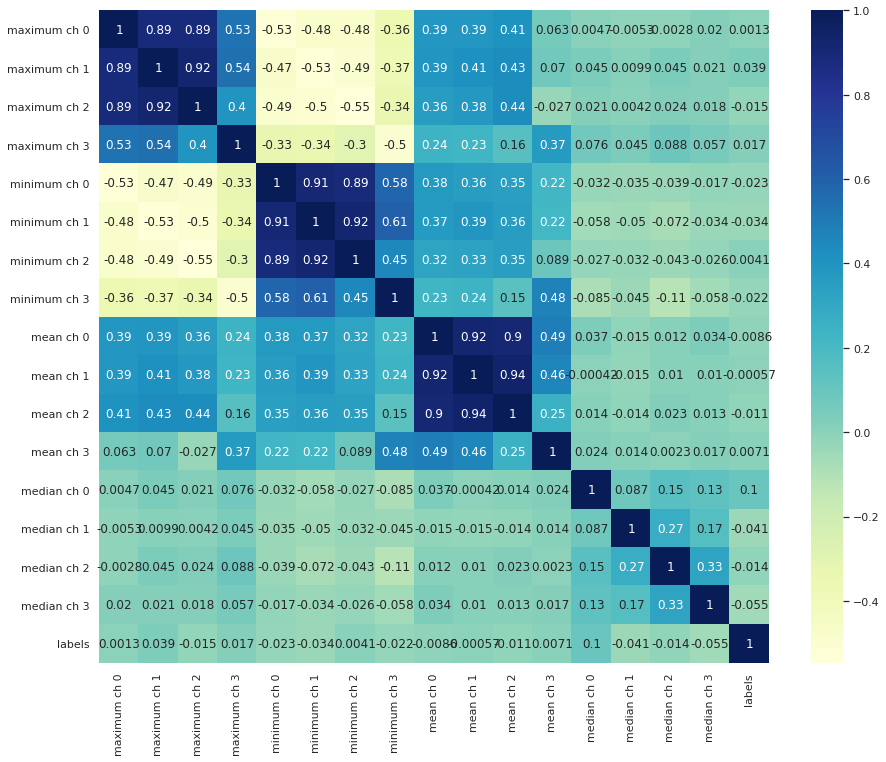

In [230]:
#sin usar labels 99
time_features_labels_only_1_2=time_features_labels[time_features_labels['labels'].isin([1, 2])]
#veo correlacion entre los features
corr_col=time_features_labels_only_1_2.corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(15,12)})
corr_col
#se ve correlacion entre features pero no entre los features y los labels


### C) Características Espectrales (en Frecuencia):
#### a) Usando BCIDataset, con el extractor de features básico de fft, genere el dataset de ejemplos utilizado como atributos el espectrograma de potencia. Determine la estrategia que considere más pertinente, si concatenar los canales o trabajar los canales en forma individual.

Se decide trabajar con todos los canales, todos los individuos y sesiones para generalizar lo mayor posible nuestro analisis.

In [66]:
#armamos un nuevo df con todos los individuos, sesiones y todos los canales
dataset_all = BCIDataset(csvs_path,window_size=750)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [67]:
metadata_all = pd.DataFrame(dataset_all.complete_metadata, columns = ['purness', 't_start', 't_end', 
                                                                      'subject', 'session'])

<IPython.core.display.Javascript object>

In [68]:
metadata_all

,purness,t_start,t_end,subject,session
0,True,0.0,3.745,MA,1
1,True,1.25,4.995,MA,1
2,True,2.5,6.245,MA,1
3,True,3.75,7.495,MA,1
4,True,5.0,8.745,MA,1
...,...,...,...,...,...
2609,True,677.5,681.245,HA,1
2610,True,678.75,682.495,HA,1
2611,True,680.0,683.745,HA,1
2612,True,681.25,684.995,HA,1


In [69]:
metadata_all.purness.value_counts()
#son False los valores impuros que contengan mas de una etiqueta 

True     2183
False     431
Name: purness, dtype: int64

In [70]:
#armo una lista de valores impuros
index = metadata_all.index
condition = metadata_all["purness"] == "False"
False_indices = index[condition]

False_indices_list = False_indices.tolist()

print(False_indices_list)


[63, 64, 71, 72, 78, 79, 87, 88, 95, 96, 103, 104, 112, 113, 120, 121, 130, 131, 138, 139, 147, 155, 156, 173, 174, 181, 182, 189, 190, 198, 206, 207, 215, 216, 225, 226, 233, 234, 243, 251, 252, 259, 260, 268, 269, 318, 326, 327, 332, 333, 341, 342, 348, 349, 357, 358, 362, 363, 371, 375, 383, 384, 411, 412, 420, 421, 424, 425, 433, 434, 438, 446, 447, 451, 452, 459, 460, 464, 465, 472, 473, 477, 478, 486, 532, 540, 541, 544, 545, 553, 554, 556, 557, 564, 565, 568, 569, 577, 582, 583, 591, 592, 600, 601, 609, 610, 615, 616, 624, 634, 635, 642, 643, 738, 746, 747, 752, 753, 760, 761, 767, 768, 776, 781, 782, 789, 790, 795, 796, 804, 809, 810, 817, 818, 824, 825, 833, 836, 837, 845, 849, 857, 858, 861, 862, 869, 870, 875, 876, 884, 885, 889, 890, 930, 931, 939, 940, 941, 949, 950, 951, 952, 959, 960, 962, 963, 970, 971, 972, 973, 981, 982, 983, 984, 991, 992, 993, 994, 1002, 1003, 1004, 1005, 1012, 1013, 1014, 1015, 1023, 1024, 1026, 1034, 1035, 1036, 1037, 1045, 1046, 1047, 1055, 1056,

In [71]:
#ver como borrar las filas que son false.

In [72]:
dataset_all.get_Y().round()

array([[99.],
       [99.],
       [99.],
       ...,
       [ 1.],
       [ 1.],
       [ 1.]])

In [73]:
dataset_all.__getitem__(80)

{'signal': array([ 758.11,  756.44,  751.85, ..., 1274.84, 1272.28, 1274.36]),
 'features': array([4.21466574e+06, 1.88797297e+02, 5.59616148e+01, ...,
        9.34683745e-02, 1.11670534e-01, 8.72641333e-04]),
 'label': array([2.]),
 'metadata': array(['True', '100.0', '103.745', 'MA', '1'], dtype='<U32')}

In [74]:
label_one = dataset_all.get_Y().round()[dataset_all.get_Y().round()==1.]
label_two = dataset_all.get_Y().round()[dataset_all.get_Y().round()==2.]
label_ninenine = dataset_all.get_Y().round()[dataset_all.get_Y().round()==99.]
print ('cantidad de etiquetas 1 ', len(label_one))
print ('cantidad de etiquetas 2 ', len(label_two))
print ('cantidad de etiquetas 99 ', len(label_ninenine))
#hay que balancear?

cantidad de etiquetas 1  481
cantidad de etiquetas 2  524
cantidad de etiquetas 99  1609


In [75]:
print ('cantidad de etiquetas 1 ', len(label_one))
print ('cantidad de etiquetas 2 ', len(label_two))
print ('cantidad de etiquetas 99 ', len(label_ninenine))
#hay que balancear?

cantidad de etiquetas 1  481
cantidad de etiquetas 2  524
cantidad de etiquetas 99  1609


In [76]:
#ejemplos con etiqueta 1
np.where(dataset_all.get_Y().round()==1.)

<IPython.core.display.Javascript object>

(array([  64,   65,   66,   67,   68,   69,   70,   71,   96,   97,   98,
          99,  100,  101,  102,  103,  131,  132,  133,  134,  135,  136,
         137,  138,  174,  175,  176,  177,  178,  179,  180,  181,  207,
         208,  209,  210,  211,  212,  213,  214,  215,  243,  244,  245,
         246,  247,  248,  249,  250,  251,  319,  320,  321,  322,  323,
         324,  325,  326,  349,  350,  351,  352,  353,  354,  355,  356,
         357,  376,  377,  378,  379,  380,  381,  382,  383,  425,  426,
         427,  428,  429,  430,  431,  432,  433,  452,  453,  454,  455,
         456,  457,  458,  459,  478,  479,  480,  481,  482,  483,  484,
         485,  486,  533,  534,  535,  536,  537,  538,  539,  540,  557,
         558,  559,  560,  561,  562,  563,  564,  616,  617,  618,  619,
         620,  621,  622,  623,  624,  739,  740,  741,  742,  743,  744,
         745,  746,  768,  769,  770,  771,  772,  773,  774,  775,  796,
         797,  798,  799,  800,  801, 

In [77]:
#ejemplos con etiqueta 2
np.where(dataset_all.get_Y().round()==2.)

<IPython.core.display.Javascript object>

(array([  79,   80,   81,   82,   83,   84,   85,   86,   87,  113,  114,
         115,  116,  117,  118,  119,  120,  147,  148,  149,  150,  151,
         152,  153,  154,  155,  190,  191,  192,  193,  194,  195,  196,
         197,  226,  227,  228,  229,  230,  231,  232,  233,  260,  261,
         262,  263,  264,  265,  266,  267,  268,  333,  334,  335,  336,
         337,  338,  339,  340,  341,  363,  364,  365,  366,  367,  368,
         369,  370,  412,  413,  414,  415,  416,  417,  418,  419,  420,
         439,  440,  441,  442,  443,  444,  445,  446,  465,  466,  467,
         468,  469,  470,  471,  472,  545,  546,  547,  548,  549,  550,
         551,  552,  553,  569,  570,  571,  572,  573,  574,  575,  576,
         577,  583,  584,  585,  586,  587,  588,  589,  590,  591,  601,
         602,  603,  604,  605,  606,  607,  608,  609,  635,  636,  637,
         638,  639,  640,  641,  642,  753,  754,  755,  756,  757,  758,
         759,  760,  782,  783,  784, 

In [78]:
dataset_all.get_X_features().shape
#tenemos 2628 ejemplos y 1504 features

(2614, 1504)

In [79]:
N=dataset_all.complete_examples_signal.shape[1]
dt = 1/200
freqs_all = np.fft.rfftfreq(n=int(N/4), d=dt)
print('shape ', freqs_all.shape)
print('resolucion ', freqs_all[1])

<IPython.core.display.Javascript object>

shape  (376,)
resolucion  0.26666666666666666


#### b) En adición, a los vectores de atributos del inciso a), generar dos estrategias adicionales de extracción de features en el dominio de la frecuencia, al menos una de ellas tiene que implicar un número de atributos <= 8. Generar los correspondientes datasets, SEAN CREATIVOS. Si reducen la información a algunas frecuencias específicas, tengan en cuenta que la frecuencia de estimulación puede no encontrarse entre los residuos de frecuencia analizados, o aún si fuera así, que la respuesta al estímulo no sea exactamente de la misma frecuencia del estímulo en sí.

In [80]:
def calc_max_filtered(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 9
    f_high = 22
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)
    
    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    
    maximum = np.argmax(Sxx, axis=1)
  
    item=freqs[maximum]
    return item.reshape((signal_matrix.shape[0], 1))

In [81]:
def filtered_range(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 9
    f_high = 22
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    
    index_low=np.where(freqs>=10)[0][0]

    index_high=np.where(freqs>=35)[0][0]


    
    
    return Sxx[:,index_low:index_high]

In [82]:
def filtered_pca(signal_matrix):
    N = signal_matrix.shape[1]
    dt = 1/200
    T = N*dt
    sf = 200
    Q = 30
    f_notch = 50
    b_notch, a_notch = sgn.iirnotch(w0=f_notch, Q=Q, fs=sf)
    sig_notch = sgn.filtfilt(b_notch, a_notch, signal_matrix, axis=1)

    #Ahora creamos el filtro pasabanda Butterworth
    f_nq = sf/2
    f_low = 10
    f_high = 35
    order = 4
    b_band, a_band = sgn.iirfilter(
        N=order, Wn=[f_low/f_nq, f_high/f_nq], btype="bandpass", ftype="butter"
    )
    sig_filt = sgn.filtfilt(b_band, a_band, sig_notch, axis=1)

    fft = np.fft.rfft(sig_filt)
    Sxx = np.real(((2*dt**2)/T)*fft*fft.conj())
    freqs = np.fft.rfftfreq(n=N, d=dt)
    
    index_low=np.where(freqs>=10)[0][0]

    index_high=np.where(freqs>=35)[0][0]    
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=3)
    pca.fit(Sxx[:,index_low:index_high])
    proyected_features_freq = pca.transform(Sxx[:,index_low:index_high])
    #proyected_features_freq.shape
    

    
    
    return proyected_features_freq.reshape((signal_matrix.shape[0], 3))

In [83]:
dataset_filtered = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_fft_features)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
dataset_filtered.__getitem__(65)

{'signal': array([ 745.66,  750.2 ,  753.44, ..., 1258.78, 1253.7 , 1261.85]),
 'features': array([1.05095750e-07, 1.28574669e-07, 2.01257582e-07, ...,
        5.10312986e-05, 5.10270868e-05, 5.10256830e-05]),
 'label': array([1.]),
 'metadata': array(['True', '81.25', '84.995', 'MA', '1'], dtype='<U32')}

In [85]:
dataset_filtered.complete_examples_features[65,1500:1504]

array([5.10383194e-05, 5.10312986e-05, 5.10270868e-05, 5.10256830e-05])

In [86]:
print('shape senal cruda ',dataset_filtered.complete_examples_signal.shape)
print('shape senal filtrada ',dataset_filtered.complete_examples_features.shape)

shape senal cruda  (2614, 3000)
shape senal filtrada  (2614, 1504)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

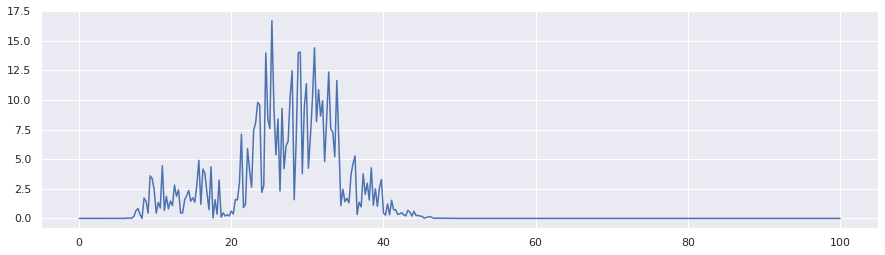

In [87]:
#ejemplo etiqueta 99
N=dataset_filtered.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=int(N/4), d=dt)

plt.figure(figsize=(15,4))
#plt.ylim([0,6])
plt.plot(freqs,dataset_filtered.complete_examples_features[2,:376])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

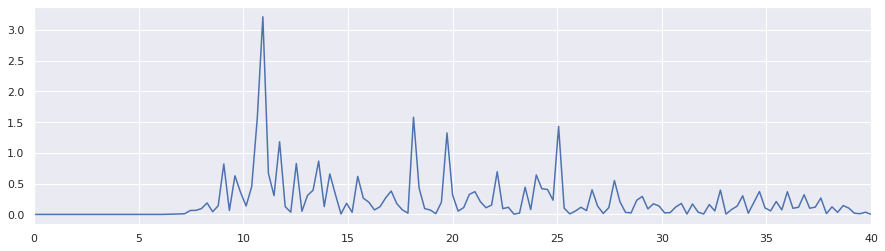

In [88]:
#ejemplo etiqueta 1
N=dataset_filtered.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=int(N/4), d=dt)

plt.figure(figsize=(15,4))
plt.xlim([0,40])
plt.plot(freqs,dataset_filtered.complete_examples_features[66,:376])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

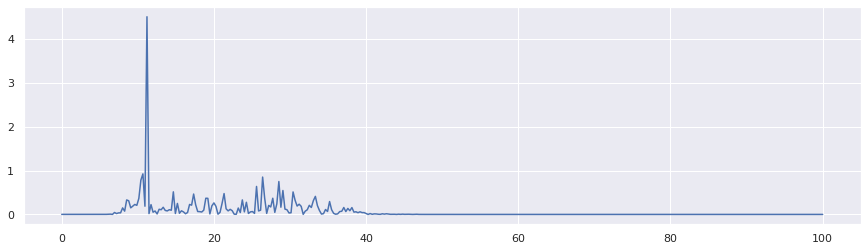

In [89]:
#ejemplo etiqueta 2
N=dataset_filtered.complete_examples_signal.shape[1]
dt = 1/200
freqs = np.fft.rfftfreq(n=int(N/4), d=dt)

plt.figure(figsize=(15,4))
#plt.xlim([0,40])
plt.plot(freqs,dataset_filtered.complete_examples_features[80,:376])

In [90]:
dataset_filtered.__getitem__(60)

{'signal': array([ 731.11,  729.51,  727.48, ..., 1263.1 , 1259.59, 1257.36]),
 'features': array([1.05777378e-03, 1.05900335e-03, 1.06270804e-03, ...,
        6.52438598e-08, 6.42762071e-08, 6.39537060e-08]),
 'label': array([99.]),
 'metadata': array(['True', '75.0', '78.745', 'MA', '1'], dtype='<U32')}

In [159]:
#dataset con los valores de frecuencia donde aparece la amplitud maxima
dataset_filtered_max = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=calc_max_filtered)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [160]:
dataset_filtered_max.complete_examples_features.shape

(2614, 4)

In [93]:
#ver de graficar histogramas cuando se pasen a df

In [193]:
#dataset con la senal filtrada y solo teniendo el rango de frecuencias importantes
dataset_filtered_range = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_range)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [169]:
dataset_filtered_range.complete_examples_features.shape
#la cantidad de features disminuyen de 1500 cuando usabamos todo el espectro de potencia a 400 si usamos solo las
#de interes

(2614, 376)

In [97]:
#dataset con la senal filtrada y aplicando pca
dataset_filtered_pca = BCIDataset(csvs_path,
                         window_size=750,
                        feature_extractor=filtered_pca)

Processing subject: MA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: JA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 0...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: AA - session: 2...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing subject: HA - session: 1...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
dataset_filtered_pca.complete_examples_features

array([[ 1.56414557e+00, -9.12701038e-01, -3.39646297e-01, ...,
         1.73579965e+00, -1.13982547e+00, -1.39616221e-02],
       [ 4.56900755e+01, -1.06791038e+01,  1.13922669e+00, ...,
         3.99249227e+01, -1.72355860e+01,  1.46894141e+00],
       [ 5.03122295e+01, -1.24627053e+01, -1.59013524e+00, ...,
         4.46699383e+01, -1.76345519e+01, -7.20691573e-01],
       ...,
       [-1.29288249e+01, -5.88468624e-01,  3.10571024e+00, ...,
        -3.53672070e+00,  6.55676885e-01,  1.69972813e+00],
       [-1.40196242e+01,  1.09559089e-01,  7.72861391e-01, ...,
        -3.56836098e+00,  1.15100593e+00,  4.03234856e-01],
       [-1.26916979e+01, -1.67906154e+00,  7.15874460e-01, ...,
        -3.37880785e+00,  1.53785553e+00, -1.66741587e+00]])

In [99]:
dataset_filtered_pca.__getitem__(1)['features']

array([ 45.69007549, -10.67910377,   1.13922669,   6.53216335,
        53.1412131 ,   0.29502021,  20.94889782,  41.56174265,
        -2.43376494,  39.92492268, -17.23558602,   1.46894141])

### c) Guarde los datasets generados de la forma que considere conveniente.

In [161]:
df_max_freq=generate_df(dataset_filtered_max.complete_examples_features,['max freq '], [0,1,2,3])
df_max_freq

<IPython.core.display.Javascript object>

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3
0,13.066667,14.933333,14.666667,13.066667
1,14.400000,14.400000,14.400000,14.400000
2,15.733333,15.733333,15.733333,15.733333
3,15.466667,15.466667,16.533333,16.266667
4,10.133333,18.933333,10.133333,10.133333
...,...,...,...,...
2609,13.333333,11.200000,11.200000,13.600000
2610,13.600000,19.733333,12.533333,13.866667
2611,13.866667,16.800000,13.866667,13.866667
2612,12.533333,15.733333,12.533333,18.666667


In [162]:
#valores maximos en etiqueta 1
df_max_freq.iloc[65:70]

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3
65,12.533333,13.333333,14.133333,12.533333
66,10.933333,18.133333,14.133333,12.533333
67,10.933333,12.533333,14.133333,14.133333
68,11.200000,12.533333,10.666667,11.733333
69,12.533333,12.266667,12.266667,12.266667


In [103]:
df_pca_freq=generate_df(dataset_filtered_pca.complete_examples_features,['pca 0 ', 'pca 1 ','pca 2 '], [0,1,2,3])
df_pca_freq

<IPython.core.display.Javascript object>

,pca 0 ch 0,pca 1 ch 0,pca 2 ch 0,pca 0 ch 1,pca 1 ch 1,pca 2 ch 1,pca 0 ch 2,pca 1 ch 2,pca 2 ch 2,pca 0 ch 3,pca 1 ch 3,pca 2 ch 3
0,1.564146,-0.912701,-0.339646,-1.143747,2.003359,-0.556500,0.486314,2.338923,0.398121,1.735800,-1.139825,-0.013962
1,45.690075,-10.679104,1.139227,6.532163,53.141213,0.295020,20.948898,41.561743,-2.433765,39.924923,-17.235586,1.468941
2,50.312229,-12.462705,-1.590135,8.732688,59.055095,0.279760,23.624202,48.039420,-3.937438,44.669938,-17.634552,-0.720692
3,48.216431,-11.240791,0.072688,8.900584,56.339039,1.280109,22.451590,44.923839,-3.612540,42.051414,-16.092515,0.150449
4,1.005834,-0.735742,-0.398817,-0.754284,1.641153,0.637028,0.127057,2.215564,0.707128,1.017174,-1.436358,-0.163044
...,...,...,...,...,...,...,...,...,...,...,...,...
2609,-11.385028,-0.914607,-0.051907,-6.260987,-1.615273,-0.369085,-3.405748,-0.442444,-0.667811,-2.781502,-0.092813,0.015556
2610,-12.408959,-0.289435,-0.249593,-7.059014,-0.779455,0.440244,-3.964438,-1.438053,-0.535736,-3.555140,1.065347,0.370959
2611,-12.928825,-0.588469,3.105710,-6.904889,-0.604987,0.591849,-4.154277,-1.674143,1.436988,-3.536721,0.655677,1.699728
2612,-14.019624,0.109559,0.772861,-6.612838,-0.209979,-1.605945,-3.763487,-1.843412,0.478739,-3.568361,1.151006,0.403235


In [104]:
df_pca_freq

,pca 0 ch 0,pca 1 ch 0,pca 2 ch 0,pca 0 ch 1,pca 1 ch 1,pca 2 ch 1,pca 0 ch 2,pca 1 ch 2,pca 2 ch 2,pca 0 ch 3,pca 1 ch 3,pca 2 ch 3
0,1.564146,-0.912701,-0.339646,-1.143747,2.003359,-0.556500,0.486314,2.338923,0.398121,1.735800,-1.139825,-0.013962
1,45.690075,-10.679104,1.139227,6.532163,53.141213,0.295020,20.948898,41.561743,-2.433765,39.924923,-17.235586,1.468941
2,50.312229,-12.462705,-1.590135,8.732688,59.055095,0.279760,23.624202,48.039420,-3.937438,44.669938,-17.634552,-0.720692
3,48.216431,-11.240791,0.072688,8.900584,56.339039,1.280109,22.451590,44.923839,-3.612540,42.051414,-16.092515,0.150449
4,1.005834,-0.735742,-0.398817,-0.754284,1.641153,0.637028,0.127057,2.215564,0.707128,1.017174,-1.436358,-0.163044
...,...,...,...,...,...,...,...,...,...,...,...,...
2609,-11.385028,-0.914607,-0.051907,-6.260987,-1.615273,-0.369085,-3.405748,-0.442444,-0.667811,-2.781502,-0.092813,0.015556
2610,-12.408959,-0.289435,-0.249593,-7.059014,-0.779455,0.440244,-3.964438,-1.438053,-0.535736,-3.555140,1.065347,0.370959
2611,-12.928825,-0.588469,3.105710,-6.904889,-0.604987,0.591849,-4.154277,-1.674143,1.436988,-3.536721,0.655677,1.699728
2612,-14.019624,0.109559,0.772861,-6.612838,-0.209979,-1.605945,-3.763487,-1.843412,0.478739,-3.568361,1.151006,0.403235


In [194]:
N=dataset_filtered_range.complete_examples_signal.shape[1]
dt = 1/200
freqs_all = np.fft.rfftfreq(n=int(N/4), d=dt)
print('shape ', freqs_all.shape)
print('resolucion ', freqs_all[1])

index_low=np.where(freqs_all>=10)[0][0]

index_high=np.where(freqs_all>=35)[0][0]

#name=str(freqs_all[index_low:index_high].round(2))
name= [str(i) for i in list(freqs_all[index_low:index_high].round(2))]

<IPython.core.display.Javascript object>

shape  (376,)
resolucion  0.26666666666666666


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [195]:
df_range_freq=pd.DataFrame(dataset_filtered_range.complete_examples_features,columns=name+name+name+name)
#df_range_freq.columns.tolist()#['13.05']

<IPython.core.display.Javascript object>

In [201]:
df_range_freq['freq_label_1_mean']=df_range_freq[['12.0','12.27','12.53','12.8','13.07']].mean(axis=1)
df_range_freq['freq_label_2_mean']=df_range_freq[[ '16.0','16.27', '16.53', '16.8','17.07']].mean(axis=1)

df_range_freq['freq_label_1_median']=np.median(df_range_freq[['12.0','12.27','12.53','12.8','13.07']],axis=1)
df_range_freq['freq_label_2_median']=np.median(df_range_freq[[ '16.0','16.27', '16.53', '16.8','17.07']],axis=1)

df_range_freq['freq_label_1_mode'] = scipy.stats.mode(df_range_freq[['12.0','12.27','12.53','12.8','13.07']]
                                                      ,axis=1)[0]
df_range_freq['freq_label_2_mode'] = scipy.stats.mode(df_range_freq[['16.0','16.27', '16.53', '16.8','17.07']]
                                                      ,axis=1)[0]
df_range_freq

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,10.13,10.4,10.67,10.93,11.2,11.47,11.73,12.0,12.27,12.53,...,34.13,34.4,34.67,34.93,freq_label_1_mean,freq_label_2_mean,freq_label_1_mode,freq_label_2_mode,freq_label_1_median,freq_label_2_median
0,0.224814,0.658278,0.051833,0.769917,0.629036,0.642783,0.065875,0.461335,0.168692,0.428235,...,0.001087,0.000967,0.000985,0.000907,0.436288,0.439057,0.019054,0.007254,0.268579,0.258492
1,0.709524,1.791293,0.380037,3.071232,0.871012,0.469457,0.093754,1.480789,1.394759,2.745288,...,0.001180,0.001121,0.001124,0.001046,1.346880,1.195726,0.167176,0.023878,1.240366,1.061345
2,0.410481,1.340503,0.888918,4.475913,0.685302,1.870490,0.813519,1.484817,1.078426,2.820585,...,0.000072,0.000121,0.000068,0.000092,1.553675,2.130857,0.343782,0.262600,1.483732,1.943594
3,0.128054,2.029702,0.829907,2.636546,2.742507,0.155437,2.811267,0.386281,1.759842,4.095491,...,0.000128,0.000205,0.000177,0.000119,1.734486,2.386360,0.386281,0.800003,1.649332,2.245953
4,5.322442,0.033701,0.150076,0.157602,0.708725,0.659126,0.463576,0.162258,0.319755,1.641941,...,0.000007,0.000006,0.000003,0.000007,0.444720,0.515093,0.037709,0.065328,0.367227,0.398659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,0.757679,5.669810,2.438031,0.580676,1.449410,5.356148,0.785060,2.683230,1.570307,2.531008,...,0.000054,0.000052,0.000045,0.000044,1.748178,1.222403,0.390764,0.235912,1.575423,0.958460
2610,1.707068,1.961632,4.345810,0.033770,0.468524,1.831768,1.204942,2.756062,2.067609,1.411686,...,0.000348,0.000319,0.000319,0.000306,1.489870,1.337795,0.139757,0.151734,1.306652,1.000573
2611,1.019336,1.495788,2.538207,0.541623,0.229575,1.566532,0.585210,1.394379,4.189949,0.760976,...,0.002752,0.002649,0.002532,0.002438,1.145906,1.080751,0.146970,0.035797,0.510505,0.474620
2612,1.835304,0.076734,3.007887,0.393964,0.229122,0.740090,0.182553,0.056615,1.567495,3.874398,...,0.000241,0.000226,0.000242,0.000234,1.116265,0.848243,0.013105,0.039474,0.410096,0.701570


### d) Repita el inciso e) del apartado B). En el caso de los vectores de pocos features realice un pairplot para visualizar en baja dimensionalidad el problema de clasificación.

In [205]:
df_max_freq['mean'] = df_max_freq.mean(axis=1)
df_max_freq['mode'] = scipy.stats.mode(df_max_freq,axis=1)[0]
df_max_freq['median']=np.median(df_max_freq,axis=1)
#df_max_freq['median'] = scipy.stats.median(df_max_freq,axis=1)[0]
df_max_freq

<IPython.core.display.Javascript object>

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,mean,mode,median
0,13.066667,14.933333,14.666667,13.066667,13.788889,13.066667,13.427778
1,14.400000,14.400000,14.400000,14.400000,14.400000,14.400000,14.400000
2,15.733333,15.733333,15.733333,15.733333,15.733333,15.733333,15.733333
3,15.466667,15.466667,16.533333,16.266667,15.855556,15.466667,15.661111
4,10.133333,18.933333,10.133333,10.133333,11.966667,10.133333,10.133333
...,...,...,...,...,...,...,...
2609,13.333333,11.200000,11.200000,13.600000,12.144444,11.200000,11.672222
2610,13.600000,19.733333,12.533333,13.866667,14.533333,12.533333,13.733333
2611,13.866667,16.800000,13.866667,13.866667,14.477778,13.866667,13.866667
2612,12.533333,15.733333,12.533333,18.666667,14.477778,12.533333,13.505556


In [206]:
max_freq_with_labels = df_max_freq.merge(labels,left_index=True,right_index=True)

In [207]:
max_freq_with_labels[max_freq_with_labels['labels']==1].head()

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,mean,mode,median,labels
64,9.866667,12.533333,16.000000,12.533333,12.700000,12.533333,12.533333,1.0
65,12.533333,13.333333,14.133333,12.533333,13.033333,12.533333,12.783333,1.0
66,10.933333,18.133333,14.133333,12.533333,13.433333,10.933333,12.983333,1.0
67,10.933333,12.533333,14.133333,14.133333,13.133333,14.133333,13.633333,1.0
68,11.200000,12.533333,10.666667,11.733333,11.388889,10.666667,11.294444,1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,mean,mode,median,labels
max freq ch 0,1.000000,0.198551,0.244354,0.243561,0.595783,0.379974,0.500356,0.088618
max freq ch 1,0.198551,1.000000,0.319742,0.269650,0.636053,0.417463,0.548900,0.069860
max freq ch 2,0.244354,0.319742,1.000000,0.425200,0.740762,0.618851,0.722642,-0.100671
max freq ch 3,0.243561,0.269650,0.425200,1.000000,0.717888,0.587449,0.687595,-0.005964
mean,0.595783,0.636053,0.740762,0.717888,1.000000,0.828812,0.949747,0.009247
mode,0.379974,0.417463,0.618851,0.587449,0.828812,1.000000,0.919776,-0.029750
median,0.500356,0.548900,0.722642,0.687595,0.949747,0.919776,1.000000,-0.014537
labels,0.088618,0.069860,-0.100671,-0.005964,0.009247,-0.029750,-0.014537,1.000000


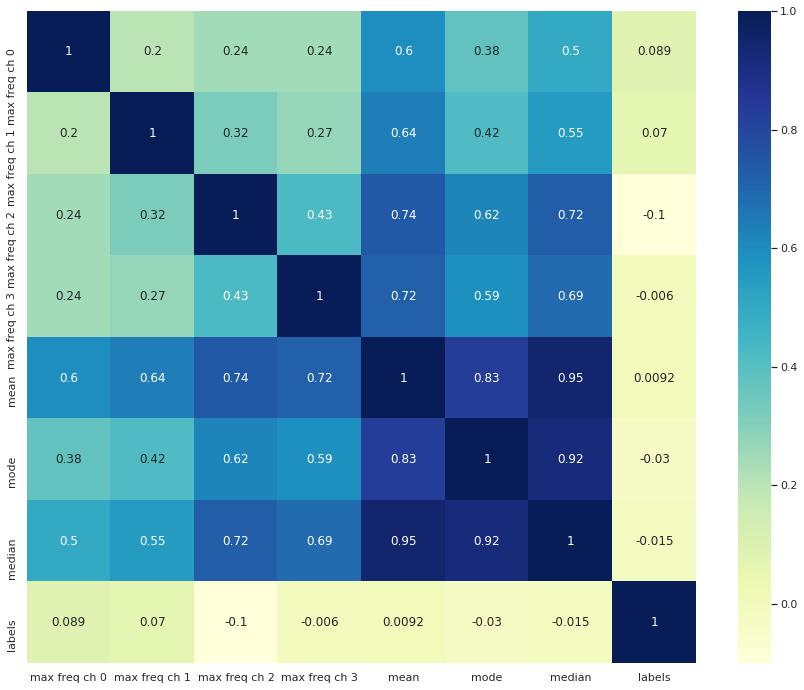

In [208]:
max_freq_with_labels_=max_freq_with_labels[max_freq_with_labels['labels'].isin([1, 2,99])]
#veo correlacion entre los features
corr_col=max_freq_with_labels_.corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(15,12)})
corr_col
#se ve correlacion entre features pero no entre los features y los labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,mean,mode,median,labels
max freq ch 0,1.000000,0.128390,0.184154,0.230655,0.549147,0.375565,0.457636,0.142574
max freq ch 1,0.128390,1.000000,0.271358,0.228297,0.570821,0.391634,0.496088,0.059339
max freq ch 2,0.184154,0.271358,1.000000,0.490814,0.745837,0.592420,0.701035,0.264233
max freq ch 3,0.230655,0.228297,0.490814,1.000000,0.757427,0.650928,0.737857,0.157733
mean,0.549147,0.570821,0.745837,0.757427,1.000000,0.850780,0.952149,0.221198
mode,0.375565,0.391634,0.592420,0.650928,0.850780,1.000000,0.938525,0.119405
median,0.457636,0.496088,0.701035,0.737857,0.952149,0.938525,1.000000,0.163970
labels,0.142574,0.059339,0.264233,0.157733,0.221198,0.119405,0.163970,1.000000


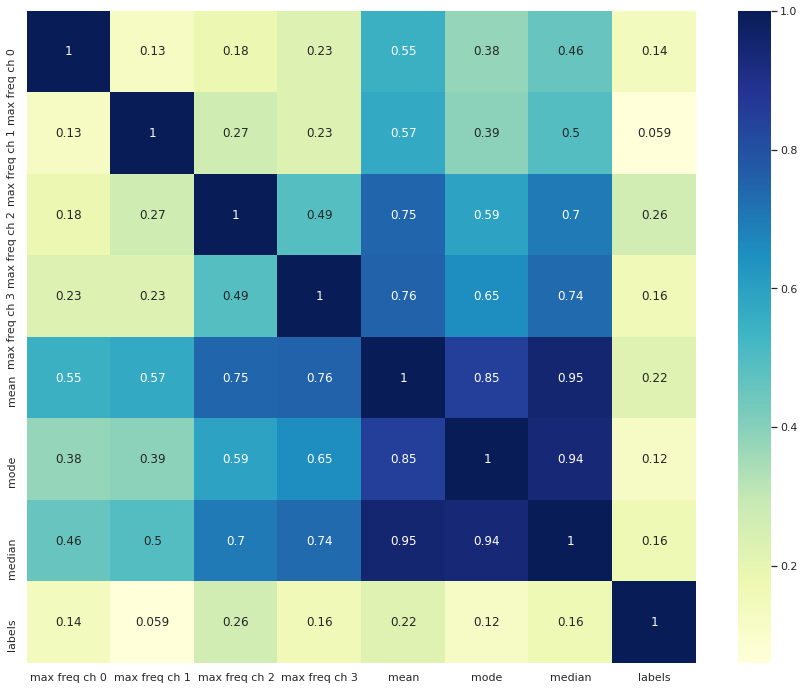

In [209]:
max_freq_with_labels_1_2=max_freq_with_labels[max_freq_with_labels['labels'].isin([1, 2])]
#veo correlacion entre los features
corr_col=max_freq_with_labels_1_2.corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(15,12)})
corr_col
#se ve correlacion entre features pero no entre los features y los labels

In [182]:
max_freq_with_labels_1_2.head(15)

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,mean,mode,labels
64,9.866667,12.533333,16.000000,12.533333,12.733333,12.533333,1.0
65,12.533333,13.333333,14.133333,12.533333,13.133333,12.533333,1.0
66,10.933333,18.133333,14.133333,12.533333,13.933333,10.933333,1.0
67,10.933333,12.533333,14.133333,14.133333,12.933333,14.133333,1.0
68,11.200000,12.533333,10.666667,11.733333,11.533333,10.666667,1.0
69,12.533333,12.266667,12.266667,12.266667,12.333333,12.266667,1.0
70,12.533333,12.533333,12.533333,12.266667,12.466667,12.533333,1.0
71,17.333333,12.266667,9.600000,15.200000,13.600000,9.600000,1.0
79,10.933333,16.533333,16.800000,16.533333,15.200000,16.533333,2.0
80,11.200000,16.533333,11.200000,11.200000,12.533333,11.200000,2.0


In [118]:
pca_with_labels = df_pca_freq.merge(labels,left_index=True,right_index=True)

In [119]:
pca_with_labels

,pca 0 ch 0,pca 1 ch 0,pca 2 ch 0,pca 0 ch 1,pca 1 ch 1,pca 2 ch 1,pca 0 ch 2,pca 1 ch 2,pca 2 ch 2,pca 0 ch 3,pca 1 ch 3,pca 2 ch 3,labels
0,1.564146,-0.912701,-0.339646,-1.143747,2.003359,-0.556500,0.486314,2.338923,0.398121,1.735800,-1.139825,-0.013962,99.0
1,45.690075,-10.679104,1.139227,6.532163,53.141213,0.295020,20.948898,41.561743,-2.433765,39.924923,-17.235586,1.468941,99.0
2,50.312229,-12.462705,-1.590135,8.732688,59.055095,0.279760,23.624202,48.039420,-3.937438,44.669938,-17.634552,-0.720692,99.0
3,48.216431,-11.240791,0.072688,8.900584,56.339039,1.280109,22.451590,44.923839,-3.612540,42.051414,-16.092515,0.150449,99.0
4,1.005834,-0.735742,-0.398817,-0.754284,1.641153,0.637028,0.127057,2.215564,0.707128,1.017174,-1.436358,-0.163044,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,-11.385028,-0.914607,-0.051907,-6.260987,-1.615273,-0.369085,-3.405748,-0.442444,-0.667811,-2.781502,-0.092813,0.015556,1.0
2610,-12.408959,-0.289435,-0.249593,-7.059014,-0.779455,0.440244,-3.964438,-1.438053,-0.535736,-3.555140,1.065347,0.370959,1.0
2611,-12.928825,-0.588469,3.105710,-6.904889,-0.604987,0.591849,-4.154277,-1.674143,1.436988,-3.536721,0.655677,1.699728,1.0
2612,-14.019624,0.109559,0.772861,-6.612838,-0.209979,-1.605945,-3.763487,-1.843412,0.478739,-3.568361,1.151006,0.403235,1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,pca 0 ch 0,pca 1 ch 0,pca 2 ch 0,pca 0 ch 1,pca 1 ch 1,pca 2 ch 1,pca 0 ch 2,pca 1 ch 2,pca 2 ch 2,pca 0 ch 3,pca 1 ch 3,pca 2 ch 3,labels
pca 0 ch 0,1.000000e+00,-6.169774e-15,3.949176e-16,7.332085e-01,-1.597904e-01,-3.676825e-01,8.031301e-01,4.066508e-01,3.696775e-02,7.319407e-01,-2.757045e-01,-2.461691e-01,0.072212
pca 1 ch 0,-6.169774e-15,1.000000e+00,-6.870021e-15,-1.549496e-01,-1.374913e-01,3.507783e-01,-3.901948e-01,5.811271e-01,1.589547e-01,-4.332466e-01,4.509797e-02,-2.568967e-01,-0.008438
pca 2 ch 0,3.949176e-16,-6.870021e-15,1.000000e+00,2.826414e-02,-2.081697e-01,1.017677e-01,1.686994e-01,-4.703614e-02,-9.581332e-02,1.101169e-01,-3.906510e-02,8.167597e-02,-0.006949
pca 0 ch 1,7.332085e-01,-1.549496e-01,2.826414e-02,1.000000e+00,2.507263e-14,9.960613e-17,6.888905e-01,1.647400e-01,1.427581e-01,6.289415e-01,-1.333603e-01,-2.938809e-01,0.073833
pca 1 ch 1,-1.597904e-01,-1.374913e-01,-2.081697e-01,2.507263e-14,1.000000e+00,1.634903e-14,-3.811616e-02,-2.317357e-01,2.412964e-01,-6.311326e-02,2.934094e-01,-6.567198e-02,0.005190
pca 2 ch 1,-3.676825e-01,3.507783e-01,1.017677e-01,9.960613e-17,1.634903e-14,1.000000e+00,-3.870363e-01,5.558980e-02,3.167794e-01,-3.492443e-01,1.992950e-01,-1.690583e-01,-0.008069
pca 0 ch 2,8.031301e-01,-3.901948e-01,1.686994e-01,6.888905e-01,-3.811616e-02,-3.870363e-01,1.000000e+00,-3.904686e-15,-7.573919e-16,9.381079e-01,-6.190148e-02,1.552028e-02,0.058069
pca 1 ch 2,4.066508e-01,5.811271e-01,-4.703614e-02,1.647400e-01,-2.317357e-01,5.558980e-02,-3.904686e-15,1.000000e+00,1.942580e-16,-1.348927e-01,-4.109475e-01,-5.112065e-01,0.023556
pca 2 ch 2,3.696775e-02,1.589547e-01,-9.581332e-02,1.427581e-01,2.412964e-01,3.167794e-01,-7.573919e-16,1.942580e-16,1.000000e+00,6.460787e-02,6.633186e-01,-5.472282e-01,0.026107
pca 0 ch 3,7.319407e-01,-4.332466e-01,1.101169e-01,6.289415e-01,-6.311326e-02,-3.492443e-01,9.381079e-01,-1.348927e-01,6.460787e-02,1.000000e+00,5.552964e-15,2.580242e-16,0.055922


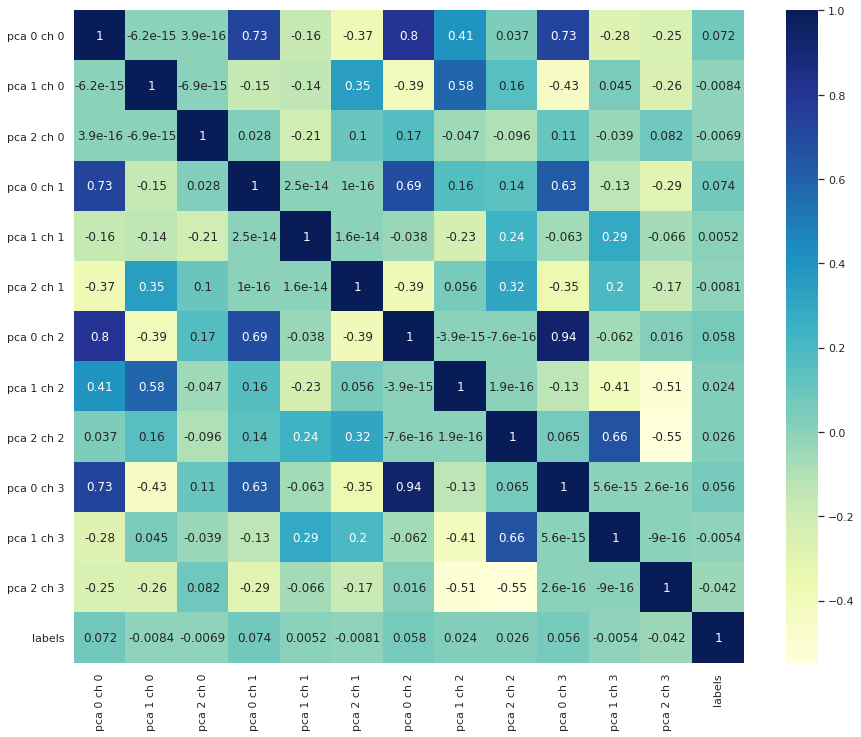

In [120]:
pca_with_labels=pca_with_labels[pca_with_labels['labels'].isin([1, 2,99])]
#veo correlacion entre los features
corr_col=pca_with_labels.corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(15,12)})
corr_col
#se ve correlacion entre features pero no entre los features y los labels

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,pca 0 ch 0,pca 1 ch 0,pca 2 ch 0,pca 0 ch 1,pca 1 ch 1,pca 2 ch 1,pca 0 ch 2,pca 1 ch 2,pca 2 ch 2,pca 0 ch 3,pca 1 ch 3,pca 2 ch 3,labels
pca 0 ch 0,1.000000,-0.999922,-0.999877,1.000000,0.999804,-0.999973,0.999998,0.999982,0.999974,1.000000,-0.999940,-0.999998,-0.008356
pca 1 ch 0,-0.999922,1.000000,0.999687,-0.999922,-0.999511,0.999870,-0.999899,-0.999946,-0.999967,-0.999926,0.999968,0.999921,0.007584
pca 2 ch 0,-0.999877,0.999687,1.000000,-0.999877,-0.999886,0.999885,-0.999894,-0.999813,-0.999776,-0.999874,0.999725,0.999877,0.009159
pca 0 ch 1,1.000000,-0.999922,-0.999877,1.000000,0.999805,-0.999974,0.999998,0.999982,0.999974,1.000000,-0.999939,-0.999998,-0.008363
pca 1 ch 1,0.999804,-0.999511,-0.999886,0.999805,1.000000,-0.999819,0.999838,0.999713,0.999654,0.999798,-0.999566,-0.999800,-0.009802
pca 2 ch 1,-0.999973,0.999870,0.999885,-0.999974,-0.999819,1.000000,-0.999977,-0.999935,-0.999933,-0.999972,0.999874,0.999970,0.008683
pca 0 ch 2,0.999998,-0.999899,-0.999894,0.999998,0.999838,-0.999977,1.000000,0.999972,0.999960,0.999997,-0.999919,-0.999996,-0.008430
pca 1 ch 2,0.999982,-0.999946,-0.999813,0.999982,0.999713,-0.999935,0.999972,1.000000,0.999984,0.999984,-0.999969,-0.999981,-0.007952
pca 2 ch 2,0.999974,-0.999967,-0.999776,0.999974,0.999654,-0.999933,0.999960,0.999984,1.000000,0.999976,-0.999969,-0.999972,-0.008239
pca 0 ch 3,1.000000,-0.999926,-0.999874,1.000000,0.999798,-0.999972,0.999997,0.999984,0.999976,1.000000,-0.999943,-0.999999,-0.008363


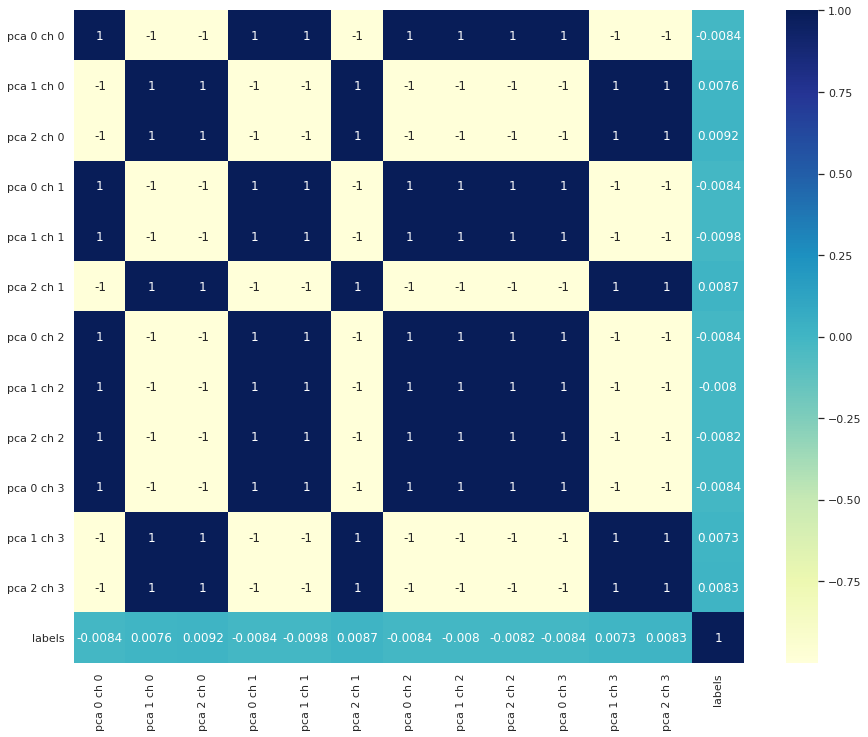

In [121]:
pca_with_labels_1_2=pca_with_labels[pca_with_labels['labels'].isin([1, 2])]
#veo correlacion entre los features
corr_col=pca_with_labels_1_2.corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(15,12)})
corr_col
#se ve correlacion entre features pero no entre los features y los labels

In [122]:
pca_with_labels

,pca 0 ch 0,pca 1 ch 0,pca 2 ch 0,pca 0 ch 1,pca 1 ch 1,pca 2 ch 1,pca 0 ch 2,pca 1 ch 2,pca 2 ch 2,pca 0 ch 3,pca 1 ch 3,pca 2 ch 3,labels
0,1.564146,-0.912701,-0.339646,-1.143747,2.003359,-0.556500,0.486314,2.338923,0.398121,1.735800,-1.139825,-0.013962,99.0
1,45.690075,-10.679104,1.139227,6.532163,53.141213,0.295020,20.948898,41.561743,-2.433765,39.924923,-17.235586,1.468941,99.0
2,50.312229,-12.462705,-1.590135,8.732688,59.055095,0.279760,23.624202,48.039420,-3.937438,44.669938,-17.634552,-0.720692,99.0
3,48.216431,-11.240791,0.072688,8.900584,56.339039,1.280109,22.451590,44.923839,-3.612540,42.051414,-16.092515,0.150449,99.0
4,1.005834,-0.735742,-0.398817,-0.754284,1.641153,0.637028,0.127057,2.215564,0.707128,1.017174,-1.436358,-0.163044,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,-11.385028,-0.914607,-0.051907,-6.260987,-1.615273,-0.369085,-3.405748,-0.442444,-0.667811,-2.781502,-0.092813,0.015556,1.0
2610,-12.408959,-0.289435,-0.249593,-7.059014,-0.779455,0.440244,-3.964438,-1.438053,-0.535736,-3.555140,1.065347,0.370959,1.0
2611,-12.928825,-0.588469,3.105710,-6.904889,-0.604987,0.591849,-4.154277,-1.674143,1.436988,-3.536721,0.655677,1.699728,1.0
2612,-14.019624,0.109559,0.772861,-6.612838,-0.209979,-1.605945,-3.763487,-1.843412,0.478739,-3.568361,1.151006,0.403235,1.0


In [202]:
freq_range_with_labels = df_range_freq.merge(labels,left_index=True,right_index=True)
freq_range_with_labels 

,10.13,10.4,10.67,10.93,11.2,11.47,11.73,12.0,12.27,12.53,...,34.4,34.67,34.93,freq_label_1_mean,freq_label_2_mean,freq_label_1_mode,freq_label_2_mode,freq_label_1_median,freq_label_2_median,labels
0,0.224814,0.658278,0.051833,0.769917,0.629036,0.642783,0.065875,0.461335,0.168692,0.428235,...,0.000967,0.000985,0.000907,0.436288,0.439057,0.019054,0.007254,0.268579,0.258492,99.0
1,0.709524,1.791293,0.380037,3.071232,0.871012,0.469457,0.093754,1.480789,1.394759,2.745288,...,0.001121,0.001124,0.001046,1.346880,1.195726,0.167176,0.023878,1.240366,1.061345,99.0
2,0.410481,1.340503,0.888918,4.475913,0.685302,1.870490,0.813519,1.484817,1.078426,2.820585,...,0.000121,0.000068,0.000092,1.553675,2.130857,0.343782,0.262600,1.483732,1.943594,99.0
3,0.128054,2.029702,0.829907,2.636546,2.742507,0.155437,2.811267,0.386281,1.759842,4.095491,...,0.000205,0.000177,0.000119,1.734486,2.386360,0.386281,0.800003,1.649332,2.245953,99.0
4,5.322442,0.033701,0.150076,0.157602,0.708725,0.659126,0.463576,0.162258,0.319755,1.641941,...,0.000006,0.000003,0.000007,0.444720,0.515093,0.037709,0.065328,0.367227,0.398659,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2609,0.757679,5.669810,2.438031,0.580676,1.449410,5.356148,0.785060,2.683230,1.570307,2.531008,...,0.000052,0.000045,0.000044,1.748178,1.222403,0.390764,0.235912,1.575423,0.958460,1.0
2610,1.707068,1.961632,4.345810,0.033770,0.468524,1.831768,1.204942,2.756062,2.067609,1.411686,...,0.000319,0.000319,0.000306,1.489870,1.337795,0.139757,0.151734,1.306652,1.000573,1.0
2611,1.019336,1.495788,2.538207,0.541623,0.229575,1.566532,0.585210,1.394379,4.189949,0.760976,...,0.002649,0.002532,0.002438,1.145906,1.080751,0.146970,0.035797,0.510505,0.474620,1.0
2612,1.835304,0.076734,3.007887,0.393964,0.229122,0.740090,0.182553,0.056615,1.567495,3.874398,...,0.000226,0.000242,0.000234,1.116265,0.848243,0.013105,0.039474,0.410096,0.701570,1.0


In [203]:
freq_range_with_labels =freq_range_with_labels [freq_range_with_labels ['labels'].isin([1, 2,99])]
#veo correlacion entre los features
corr_col=freq_range_with_labels .corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
#sns.heatmap(corr_col[['freq_label_1','freq_label_2','labels']], cmap="YlGnBu", annot = True)
#sns.set(rc={'figure.figsize':(15,12)})
corr_col[['freq_label_1_mean','freq_label_2_mean','freq_label_1_mode','freq_label_2_mode',
          'freq_label_1_median','freq_label_2_median','labels']]
#se ve correlacion entre features pero no entre los features y los labels

,freq_label_1_mean,freq_label_2_mean,freq_label_1_mode,freq_label_2_mode,freq_label_1_median,freq_label_2_median,labels
10.13,0.857887,0.858784,0.708607,0.599273,0.869360,0.842178,0.063222
10.4,0.726461,0.725863,0.449585,0.399182,0.698585,0.674741,0.060634
10.67,0.891107,0.882767,0.618167,0.600740,0.877985,0.850755,0.065396
10.93,0.585098,0.582277,0.548329,0.208005,0.535890,0.495928,0.054888
11.2,0.911447,0.900581,0.641849,0.606521,0.900606,0.873791,0.066148
...,...,...,...,...,...,...,...
freq_label_1_mode,0.777142,0.796113,1.000000,0.834130,0.812758,0.836219,0.049401
freq_label_2_mode,0.730960,0.762378,0.834130,1.000000,0.802656,0.856788,0.040282
freq_label_1_median,0.965959,0.969589,0.812758,0.802656,1.000000,0.986270,0.064962
freq_label_2_median,0.947841,0.960489,0.836219,0.856788,0.986270,1.000000,0.061087


In [204]:
freq_range_with_labels_1_2 =freq_range_with_labels [freq_range_with_labels ['labels'].isin([1, 2,])]
#veo correlacion entre los features
corr_col=freq_range_with_labels_1_2 .corr()
#.corr es una funcion que correlaciona las variables una con otra y luego la grafico con el heatmap de seaborn
#sns.heatmap(corr_col, cmap="YlGnBu", annot = True)
#sns.set(rc={'figure.figsize':(15,12)})
corr_col[['freq_label_1_mean','freq_label_2_mean','freq_label_1_mode','freq_label_2_mode',
          'freq_label_1_median','freq_label_2_median','labels']]
#se ve correlacion entre features pero no entre los features y los labels

,freq_label_1_mean,freq_label_2_mean,freq_label_1_mode,freq_label_2_mode,freq_label_1_median,freq_label_2_median,labels
10.13,0.277060,0.236940,0.127617,0.180463,0.245963,0.227236,-0.055678
10.4,0.206136,0.186977,0.102957,0.200080,0.189304,0.226753,0.000947
10.67,0.347110,0.286407,0.195706,0.257536,0.329298,0.316222,-0.090028
10.93,0.262289,0.148989,0.121853,0.065879,0.220601,0.133475,-0.076053
11.2,0.420757,0.228475,0.253629,0.226835,0.417315,0.249449,-0.004491
...,...,...,...,...,...,...,...
freq_label_1_mode,0.647994,0.413042,1.000000,0.293726,0.666633,0.421243,-0.059656
freq_label_2_mode,0.459076,0.538398,0.293726,1.000000,0.497283,0.613803,0.064897
freq_label_1_median,0.937434,0.614539,0.666633,0.497283,1.000000,0.637958,-0.105920
freq_label_2_median,0.576489,0.918605,0.421243,0.613803,0.637958,1.000000,0.192768


In [235]:
#creo un nuevo df con los features que mejor correlacion me dio.
best_features=df_max_freq.merge(df_range_freq[['freq_label_1_mean','freq_label_2_mean', 'freq_label_1_median','freq_label_2_median']],left_index=True,right_index=True)
#agrego como feature la pureza donde 1 es puro 0 impuro
best_features["purness"]=metadata_all["purness"].replace({'True':1,'False':0})

best_features

,max freq ch 0,max freq ch 1,max freq ch 2,max freq ch 3,mean,mode,median,freq_label_1_mean,freq_label_2_mean,freq_label_1_median,freq_label_2_median,purness
0,13.066667,14.933333,14.666667,13.066667,13.788889,13.066667,13.427778,0.436288,0.439057,0.268579,0.258492,1
1,14.400000,14.400000,14.400000,14.400000,14.400000,14.400000,14.400000,1.346880,1.195726,1.240366,1.061345,1
2,15.733333,15.733333,15.733333,15.733333,15.733333,15.733333,15.733333,1.553675,2.130857,1.483732,1.943594,1
3,15.466667,15.466667,16.533333,16.266667,15.855556,15.466667,15.661111,1.734486,2.386360,1.649332,2.245953,1
4,10.133333,18.933333,10.133333,10.133333,11.966667,10.133333,10.133333,0.444720,0.515093,0.367227,0.398659,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2609,13.333333,11.200000,11.200000,13.600000,12.144444,11.200000,11.672222,1.748178,1.222403,1.575423,0.958460,1
2610,13.600000,19.733333,12.533333,13.866667,14.533333,12.533333,13.733333,1.489870,1.337795,1.306652,1.000573,1
2611,13.866667,16.800000,13.866667,13.866667,14.477778,13.866667,13.866667,1.145906,1.080751,0.510505,0.474620,1
2612,12.533333,15.733333,12.533333,18.666667,14.477778,12.533333,13.505556,1.116265,0.848243,0.410096,0.701570,1


In [236]:
best_features["purness"].value_counts()
#mantengo la misma distribucion de pureza

1    2183
0     431
Name: purness, dtype: int64

Luego de no tener valores esperados con lo planteado se decide aumentar la cantidad de datos disminuyendo el tamano de la ventana (empeorando la resolucion a 0,5) y aumentando el overlapping. Sin embargo no se obtienen mejores resultados que los mostrados (se retira de la notebook para no hacer muy extensa la misma). Se decide dejar los resultados obtenidos .